

```

## **ML-Powered Job Application Success Predictor**

**Load Dataset**

link : https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohamedashraf2204","key":"dc8220ec22355fac6c596c3b19ba4a60"}'}

In [ ]:
# Step 1: Setup Kaggle API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 2: Download the dataset from Kaggle
!kaggle datasets download -d snehaanbhawal/resume-dataset

# Step 3: Unzip the dataset
!unzip resume-dataset.zip -d resume_dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [ ]:
import os

# List files inside the Resume folder
print(os.listdir("resume_dataset/Resume"))

['Resume.csv']


**EDA (Exploratory Data Analysis).**

In [ ]:
import pandas as pd

df = pd.read_csv("resume_dataset/Resume/Resume.csv")

df

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR
...,...,...,...,...
2479,99416532,RANK: SGT/E-5 NON- COMMISSIONED OFFIC...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION
2480,24589765,"GOVERNMENT RELATIONS, COMMUNICATIONS ...","<div class=""fontsize fontface vmargins hmargin...",AVIATION
2481,31605080,GEEK SQUAD AGENT Professional...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION
2482,21190805,PROGRAM DIRECTOR / OFFICE MANAGER ...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION


**Basic Info**

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB
None


In [ ]:
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64


In [ ]:
print("Shape:", df.shape)
print("Columns:", df.columns)
print("Data Types:\n", df.dtypes)

Shape: (2484, 4)
Columns: Index(['ID', 'Resume_str', 'Resume_html', 'Category'], dtype='object')
Data Types:
 ID              int64
Resume_str     object
Resume_html    object
Category       object
dtype: object


In [ ]:
print(df['Category'].value_counts())

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
ADVOCATE                  118
CHEF                      118
ENGINEERING               118
ACCOUNTANT                118
FINANCE                   118
FITNESS                   117
AVIATION                  117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64


**Data Cleaning**

In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"\[.*?\]", "", text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"\<.*?\>", "", text)
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_text'] = df['Resume_str'].apply(clean_text)

**EDA (Exploratory Data Analysis) & Visualization**

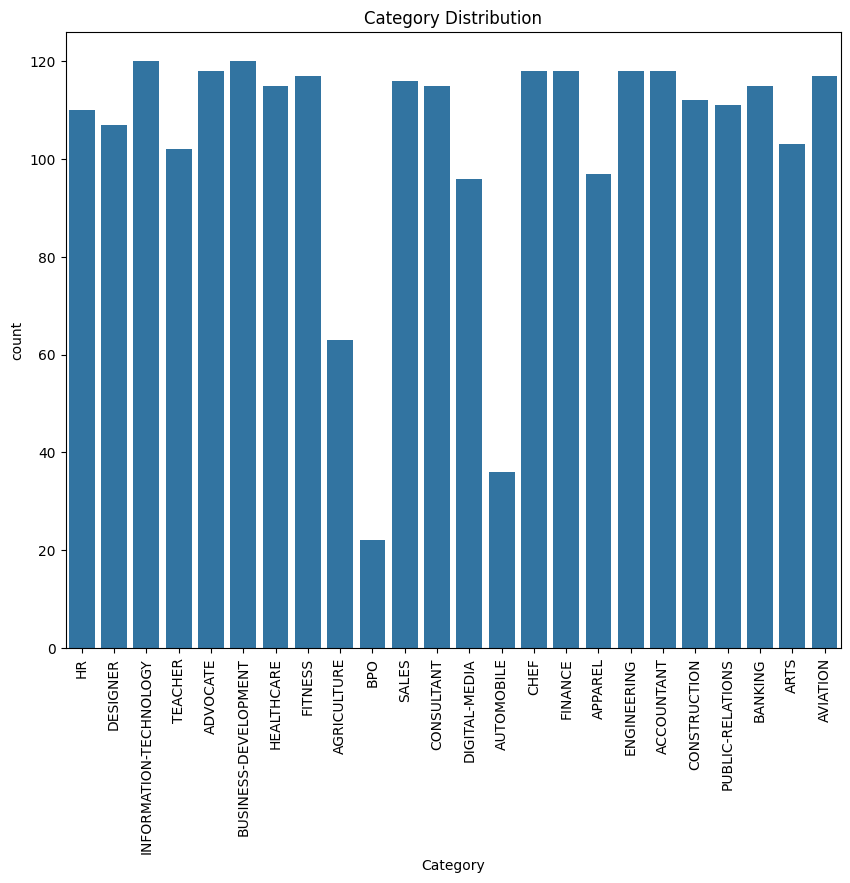

In [ ]:
# Class distribution
plt.figure(figsize=(10, 8))
sns.countplot(x='Category', data=df)
plt.title("Category Distribution")
plt.xticks(rotation=90)
plt.show()

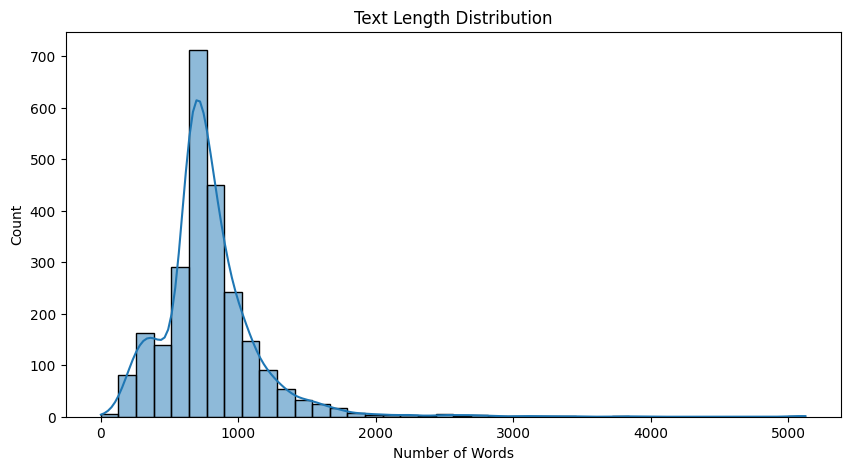

In [ ]:
# Text length
df['text_len'] = df['clean_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
sns.histplot(df['text_len'], bins=40, kde=True)
plt.title("Text Length Distribution")
plt.xlabel("Number of Words")
plt.show()

In [ ]:
fig = px.pie(df, names='Category', title='Label Distribution')
fig.update_layout(width=1000, height=500)
fig.show()

**Train-Test Split**

In [ ]:
X = df['clean_text']
y = df['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 1987
Testing set size: 497


**Vectorization (TF-IDF)**

In [ ]:
tfidf = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

**Model Training**

In [ ]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
lr_preds = lr_model.predict(X_test_tfidf)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_tfidf, y_train)
rf_preds = rf_model.predict(X_test_tfidf)

**Encoding for XGBoost**

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode string labels to integers
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)


In [ ]:
# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_tfidf, y_train_encoded)
xgb_preds_encoded = xgb_model.predict(X_test_tfidf)

# Decode predictions back to original labels
xgb_preds = le.inverse_transform(xgb_preds_encoded)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning:

[08:00:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.





Logistic Regression Classification Report:

                        precision    recall  f1-score   support

            ACCOUNTANT       0.67      0.83      0.74        24
              ADVOCATE       0.33      0.50      0.40        24
           AGRICULTURE       1.00      0.23      0.38        13
               APPAREL       0.60      0.16      0.25        19
                  ARTS       0.55      0.29      0.38        21
            AUTOMOBILE       0.00      0.00      0.00         7
              AVIATION       0.81      0.71      0.76        24
               BANKING       0.83      0.65      0.73        23
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.46      0.79      0.58        24
                  CHEF       0.81      0.71      0.76        24
          CONSTRUCTION       0.78      0.82      0.80        22
            CONSULTANT       0.43      0.13      0.20        23
              DESIGNER       0.81      0.81      0.81     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



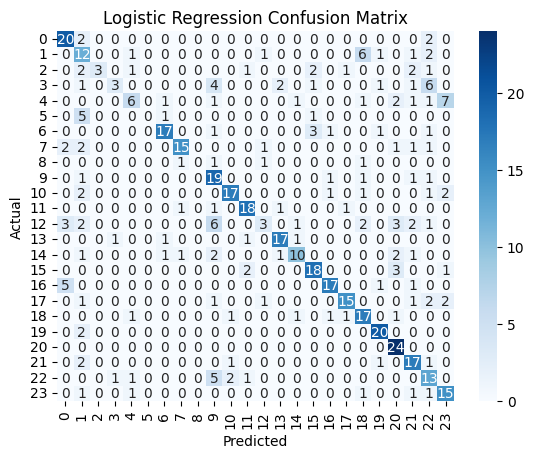


Random Forest Classification Report:

                        precision    recall  f1-score   support

            ACCOUNTANT       0.59      0.96      0.73        24
              ADVOCATE       0.65      0.71      0.68        24
           AGRICULTURE       0.78      0.54      0.64        13
               APPAREL       0.75      0.32      0.44        19
                  ARTS       0.50      0.10      0.16        21
            AUTOMOBILE       0.00      0.00      0.00         7
              AVIATION       0.81      0.88      0.84        24
               BANKING       0.84      0.70      0.76        23
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.52      0.67      0.58        24
                  CHEF       0.86      0.79      0.83        24
          CONSTRUCTION       0.73      0.86      0.79        22
            CONSULTANT       0.43      0.13      0.20        23
              DESIGNER       0.78      0.86      0.82        21


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



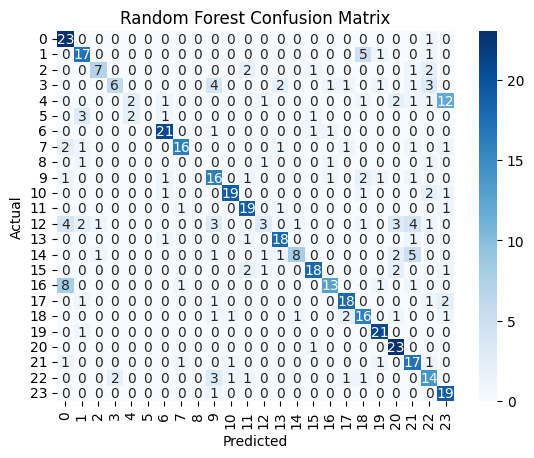


XGBoost Classification Report:

                        precision    recall  f1-score   support

            ACCOUNTANT       0.79      0.96      0.87        24
              ADVOCATE       0.81      0.88      0.84        24
           AGRICULTURE       1.00      0.62      0.76        13
               APPAREL       0.54      0.37      0.44        19
                  ARTS       0.52      0.57      0.55        21
            AUTOMOBILE       0.60      0.43      0.50         7
              AVIATION       0.81      0.71      0.76        24
               BANKING       0.94      0.70      0.80        23
                   BPO       0.75      0.75      0.75         4
  BUSINESS-DEVELOPMENT       0.68      0.62      0.65        24
                  CHEF       1.00      0.79      0.88        24
          CONSTRUCTION       0.88      0.95      0.91        22
            CONSULTANT       0.61      0.48      0.54        23
              DESIGNER       0.84      1.00      0.91        21
      

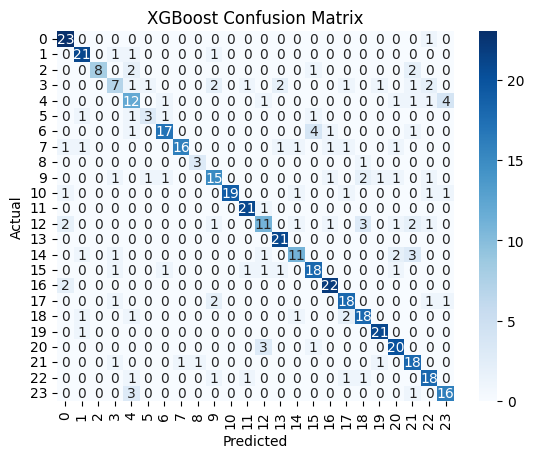

In [ ]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Classification Report:\n")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

evaluate_model("Logistic Regression", y_test, lr_preds)
evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("XGBoost", y_test, xgb_preds)

In [ ]:
import joblib

# Save the model
joblib.dump(xgb_model, 'xgb_model.joblib')

['xgb_model.joblib']